## Initial Set-Up

<h1>Resizing Images</h1>

We'll be using the [resize (cv2) function](https://www.opencv.org.cn/opencvdoc/2.3.2/html/modules/imgproc/doc/geometric_transformations.html#cv2.resize)

In [1]:
!pip install opencv-python
!pip install tqdm
!pip install tensorflow
!pip install torch

^C
Traceback (most recent call last):
  File "/bin/pip", line 11, in <module>
    load_entry_point('pip==20.0.2', 'console_scripts', 'pip')()
  File "/usr/lib/python3/dist-packages/pkg_resources/__init__.py", line 490, in load_entry_point
    return get_distribution(dist).load_entry_point(group, name)
  File "/usr/lib/python3/dist-packages/pkg_resources/__init__.py", line 2854, in load_entry_point
    return ep.load()
  File "/usr/lib/python3/dist-packages/pkg_resources/__init__.py", line 2445, in load
    return self.resolve()
  File "/usr/lib/python3/dist-packages/pkg_resources/__init__.py", line 2451, in resolve
    module = __import__(self.module_name, fromlist=['__name__'], level=0)
  File "/usr/lib/python3/dist-packages/pip/_internal/cli/main.py", line 10, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/usr/lib/python3/dist-packages/pip/_internal/cli/autocompletion.py", line 9, in <module>
    from pip._internal.cli.main_parser import create_mai

In [2]:
import cv2
import os
import numpy as np
from tqdm import tqdm # progress bar

In [ ]:
from genericpath import isdir
directory = "../mirflickr"
count = 0
# iterate through each file in the dir and push file data into imgs list
if not os.path.isdir(directory):
   os.makedirs(directory)

for filename in tqdm(os.listdir(directory)):
    filepath = os.path.join(directory, filename)
    img = cv2.imread(filepath)
    
    if '.jpg' not in filename:
        continue
    
    try:
        hr_output = './imgs-hr/' + filename
        lr_output = './imgs-lr/' + filename
        hr_img = cv2.resize(img, np.array([128, 128]))
        lr_img = cv2.resize(img, np.array([32, 32]))

        cv2.imwrite(hr_output, hr_img)
        cv2.imwrite(lr_output, lr_img)
    except Exception as e:
        print('failed to resize ', hr_output, e)
        print(filename)
        print(img)

0it [00:00, ?it/s]


<h1>Building Model</h1>

In [50]:
# imports
import tensorflow as tf
from keras import Input, Model
from keras.applications import VGG19
from keras.layers import BatchNormalization, Activation, LeakyReLU, Add, Dense, PReLU, Flatten
from keras.layers.convolutional import Conv2D, UpSampling2D
from tensorflow.keras.models import load_model

In [4]:
#residual blocks
def get_residual_block(a):
    x = Conv2D(64, kernel_size = (3, 3), strides=(1, 1), padding='same', input_shape=[32, 32, 64], activation='relu')(a)
    x = BatchNormalization()(x)
    x = PReLU()(x)
    x = Conv2D(64, kernel_size = (3, 3), strides=(1, 1), padding='same', input_shape=[32, 32, 64], activation='relu')(x)
    x = BatchNormalization()(x)
    a = Add()([x, a])

    return a
    
    
# create generator network
def create_generator_network():
    inputs = Input(shape=(32, 32, 3))

    # original 2 layers
    #changed kernel to 3x3 from 9x9
    a = Conv2D(64, kernel_size = (9, 9), strides=(1, 1), padding='same', input_shape=[32, 32, 3], activation='relu')(inputs)
    a = PReLU()(a)

    # keep track of a to sum it into the result of the residiual block methods
    orig = a

    for i in range(0, 5):
        a = get_residual_block(a)

    x = Conv2D(64, kernel_size = (3, 3), strides=(1, 1), padding='same', input_shape=[32, 32, 64], activation='relu')(a)
    x = BatchNormalization()(x)

    a = Add()([x, orig])

    for i in range(0, 2):
        # pixel shuffle
        a = Conv2D(256, kernel_size = (3, 3), strides=(1, 1), padding='same', input_shape=[32, 32, 64], activation='relu')(a)
        a = UpSampling2D()(a)
        a = UpSampling2D()(a)
        a = PReLU()(a)

    a = Conv2D(3, kernel_size = (9, 9), strides=(1, 1), padding='same', input_shape=[32, 32, 64], activation='relu')(a)

    return Model(inputs=inputs, outputs=a)



In [54]:
# create discriminator network
def create_discriminator_network(disc_ip):
    x = Conv2D(64, kernel_size = (3, 3), strides=(1, 1), padding='same', input_shape=[32, 32, 3], activation='relu')(inputs)
    x = LeakyReLU(alpha= 0.2)(x)

    
    x = Conv2D(64, kernel_size = (3, 3), strides=(2, 2), padding='same', input_shape=[32, 32, 64], activation='relu')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.2)(x)

    x = Conv2D(128, kernel_size = (3, 3), strides=(1, 1), padding='same', input_shape=[32, 32, 64], activation='relu')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.2)(x)

    x = Conv2D(128, kernel_size = (3, 3), strides=(2, 2), padding='same', input_shape=[32, 32, 128], activation='relu')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.2)(x)

    x = Conv2D(256, kernel_size = (3, 3), strides=(1, 1), padding='same', input_shape=[32, 32, 128], activation='relu')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.2)(x)

    x = Conv2D(256, kernel_size = (3, 3), strides=(2, 2), padding='same', input_shape=[32, 32, 256], activation='relu')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.2)(x)

    x = Conv2D(512, kernel_size = (3, 3), strides=(1, 1), padding='same', input_shape=[32, 32, 256], activation='relu')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.2)(x)

    x = Conv2D(512, kernel_size = (3, 3), strides=(2, 2), padding='same', input_shape=[32, 32, 512], activation='relu')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.2)(x)

    x = Flatten()(x)
    x = Dense(1024)(x)
    x = LeakyReLU(alpha = 0.2)(x)
    x = Dense(1, activation='sigmoid')(x)

    return Model(disc_ip, x)

In [6]:
from keras.models import Model

In [7]:
#content loss 

def vgg_loss_function(hr_img):
    vgg = VGG19(include_top=False, weights='imagenet', input_shape=hr_img)
    model = Model(inputs = vgg.inputs, outputs = vgg.layers[10].output) #calling 512 
    return model

In [55]:
#combined model

def combined_model(generator_network, discriminator_network, 
                   vgg, hr_img, lr_img):

    generative_img = generator_network(lr_img)

    generative_features = vgg(generative_img)


    discriminator_network.trainable = False
    validity = create_discriminator_network(generative_features)

    model = Model(inputs=[lr_img, hr_img], outputs=[validity, generative_features])
    return model

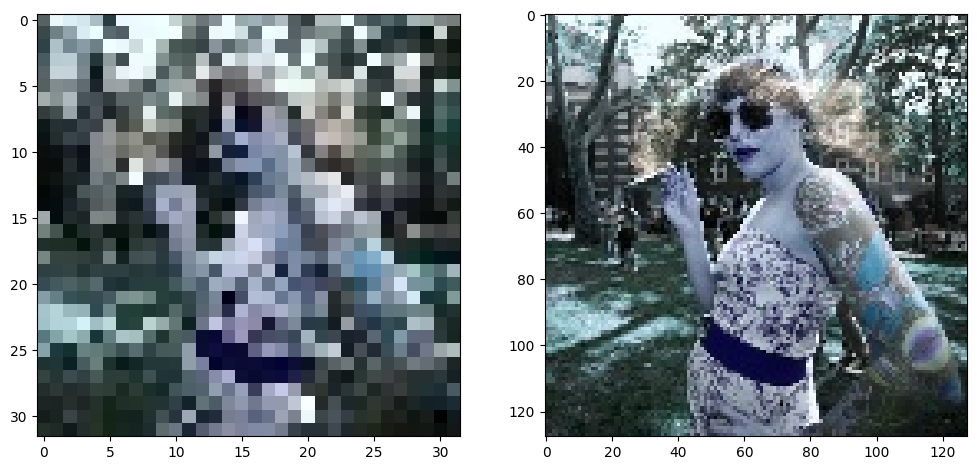

In [ ]:
#Sanity check, view few images
import random
import numpy as np
import matplotlib.pyplot as plt
lr_images = []
hr_images = []
directory = './imgs-lr'
i = 0
for filename in os.listdir(directory):
    if i < 5:
        filepath = os.path.join(directory, filename)
        img = cv2.imread(filepath)
        lr_images.append(img)
        i += 1
    else:
        break
directory = './imgs-hr'
i = 0
for filename in os.listdir(directory):
    if i < 5:
        filepath = os.path.join(directory, filename)
        img = cv2.imread(filepath)
        hr_images.append(img)
        i += 1
    else:
        break
lr_images = np.array(lr_images)
hr_images = np.array(hr_images)
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (32, 32, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (128, 128, 3)))
plt.show()

In [9]:
lr_images = []
hr_images = []
directory = './imgs-lr'
count = 0
for filename in tqdm(os.listdir(directory)):
    if count > 5000:
        continue
    filepath = os.path.join(directory, filename)
    img = cv2.imread(filepath)
    lr_images.append(img)
    count += 1
directory = './imgs-hr'
count = 0
for filename in tqdm(os.listdir(directory)):
    if count > 5000:
        break
    filepath = os.path.join(directory, filename)
    img = cv2.imread(filepath)
    hr_images.append(img)
    count += 1
lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

 10%|█         | 5001/50000 [00:31<04:43, 158.48it/s]


In [10]:
#inializing parameters
from keras.optimizers import Adam
epochs = 100
batch_size = 50
steps_per_epoch = 5000 / batch_size
optimizer = Adam(lr=1e-3)

/home/kshashank/.local/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [11]:
lr_images = lr_images / 255
hr_images = hr_images / 255

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images,
                                                        test_size=0.20, random_state=42)


In [14]:
hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])


In [15]:
lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)


In [16]:
generator = create_generator_network()
generator.summary()


2022-12-04 12:50:41.131317: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-04 12:50:41.131486: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kshashank/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-12-04 12:50:41.131550: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kshashank/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-12-04 12:50:41.131610: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dle

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   15616       ['input_3[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 32, 32, 64)   65536       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   36928       ['p_re_lu[0][0]']                
                                                                                              

In [17]:
discriminator = create_discriminator_network(hr_ip)
discriminator.compile(loss="binary_crossentropy",
                      optimizer="adam", metrics=['accuracy'])
discriminator.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 16, 16, 64)        36928     
                                                                 
 batch_normalization_11 (Bat  (None, 16, 16, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                           

In [18]:
vgg = vgg_loss_function(hr_shape)
print(vgg.summary())
vgg.trainable = False


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [42]:
print(hr_ip)
print(lr_ip)

KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


In [56]:
gan_model = combined_model(generator, discriminator, vgg, hr_ip, lr_ip)


ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_17'), name='input_17', description="created by layer 'input_17'") at layer "conv2d_111". The following previous layers were accessed without issue: []

In [35]:
gan_model.compile(loss=["binary_crossentropy", "mse"],
                  loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 model (Functional)             (None, 512, 512, 3)  72921027    ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           (None, 2, 2, 1)      5219137     ['model[0][0]']            

In [36]:
batch_size = 20
train_lr_batches = []
train_hr_batches = []
for i in range(int(hr_train.shape[0] / batch_size)):
    start_idx = i * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])


In [ ]:
epochs = 5
#Enumerate training over epochs
for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    generator_losses = []
    discrimator_losses = []
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        
        #First, train the discriminator on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    #Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    #Report the progress during training. 
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 10 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("gen_e_"+ str(e+1) +".h5")